1. Use a dataset of the City of Houston that has information about traffic counts in different sections of the city. Can be downloaded from here:
https://github.com/computingcelts/f25-ds-examples/blob/main/datasets/TrafficCounts_OpenData_wm.csv

The metadata information can be found here: 
https://bit.ly/tfcounts 
Not all the metadata will be useful for this analysis, you can make decisions about what will be useful and which not.

2. Create a jupyter notebook by using as a template the one provided above for K-Means.

# part 1: 
importing data and selecting which columns to use. Dropped cells with missing values.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# preparing for clusteriong
# we will only need these. 
df = df[['ADT', 'POINT_X', 'POINT_Y', 'PERCENTILESPEED85', 'COLLECTIONTYPE', 'YEAR', 'SEGMENT', 'STREETNAME']]
# drops missing values
df = df.dropna(subset=['ADT', 'POINT_X', 'POINT_Y'])

# loading data set: 
df = pd.read_csv("TrafficCounts_OpenData_wm.csv")
df.head()

,OBJECTID,SEGMENT,ADT,ID,STREETNAME,STREETADDRESS,FILENAME,PERCENTILESPEED85,OUTCOME,COLLECTIONTYPE,X,Y,YEAR,PRE_NTMP_ADT,POST_NTMP_ADT,PRE_NTMP_SPEED,POST_NTMP_SPEED,POINT_X,POINT_Y
0,1,E CITY LIMIT TO EL DORADO,7464,376,CLEAR LAKE CITY,4422,0376,NaN,SUCCESS,MAJOR THOROUGHFARE ADT,3203065.10,13788908.31,2012,NaN,NaN,NaN,NaN,-95.114007,29.607417
1,2,WAUGH TO WESTHEIMER,6182,399,COMMONWEALTH,2301,0399,NaN,SUCCESS,MAJOR THOROUGHFARE ADT,3111756.64,13837022.34,2011,NaN,NaN,NaN,NaN,-95.396562,29.747705
2,3,BELLAIRE TO ALIEF CLODINE,11884,402,COOK,4545,0402,NaN,SUCCESS,MAJOR THOROUGHFARE ADT,3048851.90,13820339.19,2011,NaN,NaN,NaN,NaN,-95.596247,29.707028
3,4,S POST OAK TO CHIMNEY ROCK,5234,407,COURT,6200,0407,NaN,SUCCESS,MAJOR THOROUGHFARE ADT,3087091.19,13779039.25,2011,NaN,NaN,NaN,NaN,-95.479757,29.590387
4,5,SOUTH LOOP TO BELLFORT,4275,414,CRESTMONT,7019,0414,NaN,SUCCESS,MAJOR THOROUGHFARE ADT,3134106.28,13811599.52,2012,NaN,NaN,NaN,NaN,-95.328678,29.675914


# part 2: 
plotting some histograms for ADT and Percentile speed

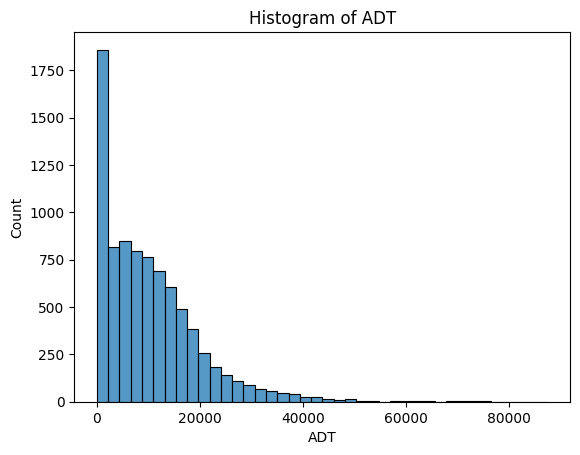

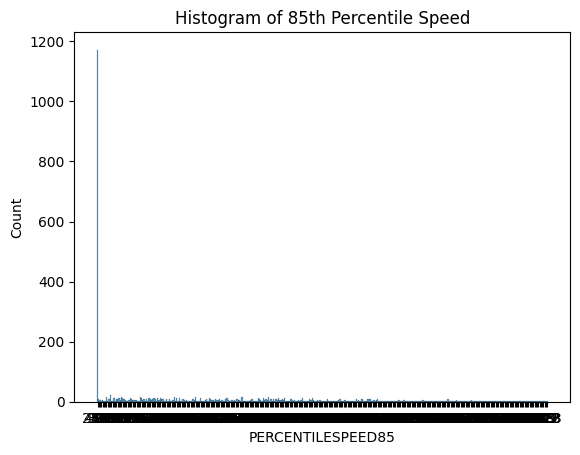

In [ ]:
df[['ADT','PERCENTILESPEED85' ]]. describe()

sns.histplot(df['ADT'], bins=40)
plt.title("Histogram of ADT")
plt.show()

sns.histplot(df['PERCENTILESPEED85'], bins=40)
plt.title("Histogram of 85th Percentile Speed")
plt.show()

# part 3:
Feature Engineering. Created 3 new features.

In [20]:
import numpy as np
numeric_cols = ['ADT', 'PERCENTILESPEED85', 'POINT_X', 'POINT_Y']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=numeric_cols)

# log transform ADT
df['log_ADT'] = np.log1p(df['ADT'])

# distance from downtown
cx, cy = 29.7604, -95.3698
df['dist_from_center'] = np.sqrt((df['POINT_Y'] - cx)**2 + (df['POINT_X'] - cy)**2)

# numeric COLLECTIONTYPE
df['is_major'] = (df['COLLECTIONTYPE'] == 'MAJOR THOROUGHFARE ADT').astype(int)

# Final features for clustering
features = ['log_ADT', 'POINT_X', 'POINT_Y', 'PERCENTILESPEED85', 'is_major', 'dist_from_center']
X = df[features]

# Check first rows
X.head()

,log_ADT,POINT_X,POINT_Y,PERCENTILESPEED85,is_major,dist_from_center
9,9.882111,-95.355620,29.665667,0.0,1,0.095788
10,8.692994,-95.309486,29.680596,0.0,1,0.100032
11,8.496174,-95.369235,29.729153,0.0,1,0.031252
23,10.182444,-95.473174,29.838636,0.0,1,0.129642
33,10.029415,-95.521788,29.788203,0.0,1,0.154510


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# k-means with 2 clusters

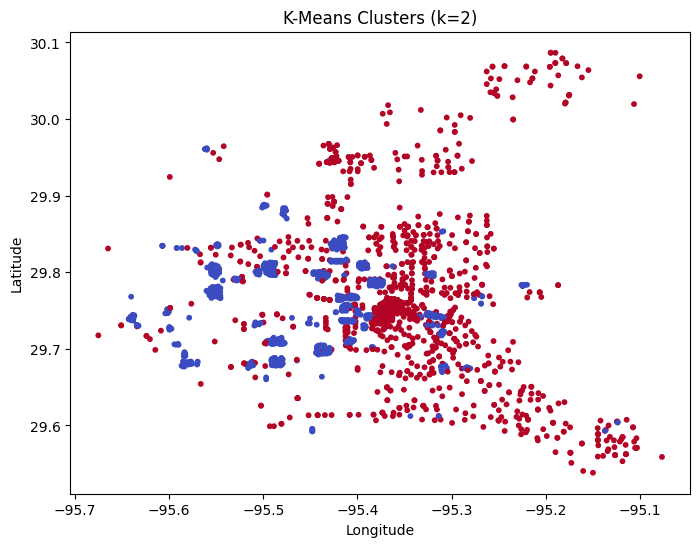

,log_ADT,POINT_X,POINT_Y,PERCENTILESPEED85,is_major,dist_from_center,ADT_estimate
0,6.592287,-95.445494,29.757264,29.279247,0.012903,0.107314,728.447379
1,9.059506,-95.351692,29.763988,14.354719,0.997750,0.081130,8598.900024


In [23]:
from sklearn.cluster import KMeans

k2 = KMeans(n_clusters=2, random_state=42, n_init=20)
df['k2_cluster'] = k2.fit_predict(X_scaled)

#plotting the clusters: 
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df['POINT_X'], df['POINT_Y'], c=df['k2_cluster'], cmap='coolwarm', s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clusters (k=2)')
plt.show()

# inspecting centroids: 
centroids_scaled = k2.cluster_centers_
centroids_orig = scaler.inverse_transform(centroids_scaled)

centroids_df = pd.DataFrame(centroids_orig, columns=features)
centroids_df['ADT_estimate'] = np.expm1(centroids_df['log_ADT'])
centroids_df



# K-means with 3 clusters: 

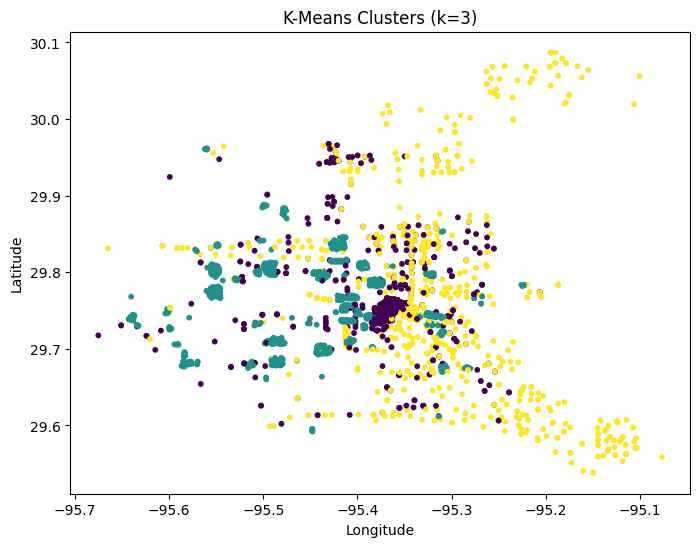

,log_ADT,POINT_X,POINT_Y,PERCENTILESPEED85,is_major,dist_from_center,ADT_estimate
0,8.935501,-95.372967,29.761332,0.703377,1.000000,0.042292,7595.941259
1,6.563884,-95.445748,29.757230,28.691930,0.004362,0.105522,708.019919
2,9.275226,-95.314606,29.768725,40.297940,0.985849,0.154779,10669.367992


In [25]:
k3 = KMeans(n_clusters=3, random_state=42, n_init=20)
df['k3_cluster'] = k3.fit_predict(X_scaled)

#plotting: 
plt.figure(figsize=(8,6))
plt.scatter(df['POINT_X'], df['POINT_Y'], c=df['k3_cluster'], cmap='viridis', s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clusters (k=3)')
plt.show()

# centroids:
centroids_scaled3 = k3.cluster_centers_
centroids_orig3 = scaler.inverse_transform(centroids_scaled3)

centroids_df3 = pd.DataFrame(centroids_orig3, columns=features)
centroids_df3['ADT_estimate'] = np.expm1(centroids_df3['log_ADT'])
centroids_df3


# Loop for k=3 and 10 and compute SSE

In [28]:
inertias = []
all_centroids = {}

for k in range(3, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    
    cent_orig = scaler.inverse_transform(km.cluster_centers_)
    cent_df = pd.DataFrame(cent_orig, columns=features)
    cent_df['ADT_estimate'] = np.expm1(cent_df['log_ADT'])
    all_centroids[k] = cent_df


# Elbow graph

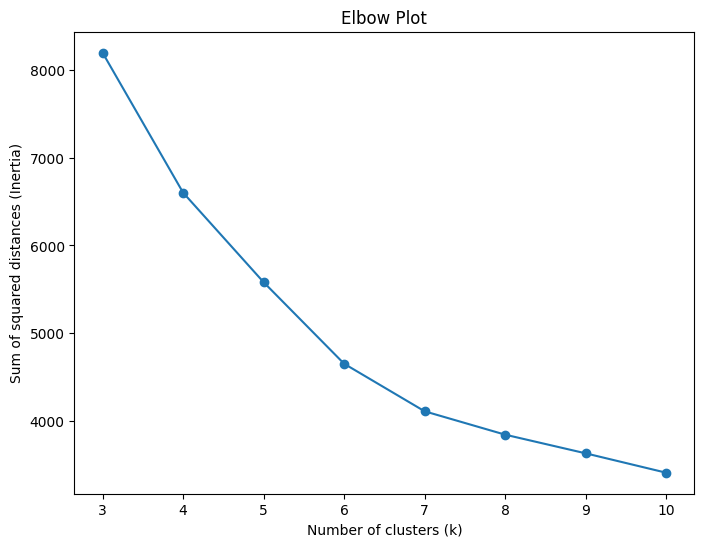

In [27]:
plt.figure(figsize=(8,6))
plt.plot(range(3, 11), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (Inertia)')
plt.title('Elbow Plot')
plt.show()


Print centroid characteristics for each k

In [29]:
for k, cent in all_centroids.items():
    print(f"\n--- k = {k} ---")
    display(cent.round(2))


--- k = 3 ---


,log_ADT,POINT_X,POINT_Y,PERCENTILESPEED85,is_major,dist_from_center,ADT_estimate
0,8.94,-95.37,29.76,0.70,1.00,0.04,7595.94
1,6.56,-95.45,29.76,28.69,0.00,0.11,708.02
2,9.28,-95.31,29.77,40.30,0.99,0.15,10669.37



--- k = 4 ---


,log_ADT,POINT_X,POINT_Y,PERCENTILESPEED85,is_major,dist_from_center,ADT_estimate
0,9.41,-95.26,29.65,33.69,0.98,0.17,12206.05
1,8.91,-95.37,29.76,4.56,1.00,0.03,7421.61
2,6.56,-95.45,29.76,29.00,0.00,0.10,707.86
3,9.26,-95.36,29.92,36.63,0.99,0.19,10505.36



--- k = 5 ---


,log_ADT,POINT_X,POINT_Y,PERCENTILESPEED85,is_major,dist_from_center,ADT_estimate
0,8.93,-95.37,29.76,0.07,1.00,0.04,7539.44
1,9.29,-95.34,29.98,32.63,0.98,0.24,10816.34
2,6.56,-95.45,29.76,28.69,0.00,0.10,705.93
3,9.65,-95.19,29.61,27.74,0.95,0.24,15528.71
4,9.09,-95.36,29.75,41.75,1.00,0.09,8830.45



--- k = 6 ---


,log_ADT,POINT_X,POINT_Y,PERCENTILESPEED85,is_major,dist_from_center,ADT_estimate
0,6.50,-95.39,29.76,27.96,0.01,0.06,666.27
1,9.08,-95.35,29.75,41.54,1.00,0.09,8774.87
2,8.93,-95.37,29.76,0.05,1.00,0.03,7517.87
3,9.32,-95.33,29.98,32.68,1.00,0.24,11139.41
4,6.81,-95.53,29.75,29.73,0.06,0.18,907.89
5,9.65,-95.19,29.61,27.33,0.95,0.24,15508.73



--- k = 7 ---


,log_ADT,POINT_X,POINT_Y,PERCENTILESPEED85,is_major,dist_from_center,ADT_estimate
0,9.38,-95.30,29.99,42.96,1.00,0.25,11812.51
1,8.86,-95.36,29.75,0.05,1.00,0.02,7052.49
2,9.54,-95.49,29.83,7.88,1.00,0.18,13910.22
3,6.65,-95.53,29.75,29.77,0.00,0.17,772.85
4,9.07,-95.35,29.75,41.59,1.00,0.08,8691.39
5,6.50,-95.39,29.76,27.96,0.01,0.06,666.27
6,9.65,-95.19,29.61,27.33,0.95,0.24,15508.73



--- k = 8 ---


,log_ADT,POINT_X,POINT_Y,PERCENTILESPEED85,is_major,dist_from_center,ADT_estimate
0,8.86,-95.36,29.75,0.05,1.00,0.02,7027.57
1,6.51,-95.39,29.76,27.94,0.00,0.06,668.30
2,9.28,-95.39,29.88,46.53,0.99,0.15,10699.08
3,6.64,-95.53,29.75,29.73,0.00,0.17,766.70
4,9.66,-95.19,29.60,27.04,0.95,0.24,15705.56
5,9.01,-95.35,29.72,40.05,1.00,0.08,8187.69
6,9.56,-95.48,29.84,1.22,1.00,0.17,14200.40
7,9.47,-95.23,30.04,43.50,1.00,0.32,12964.96



--- k = 9 ---


,log_ADT,POINT_X,POINT_Y,PERCENTILESPEED85,is_major,dist_from_center,ADT_estimate
0,6.51,-95.39,29.76,27.94,0.00,0.06,668.30
1,9.35,-95.38,29.89,0.05,1.00,0.15,11528.22
2,9.03,-95.35,29.78,39.78,1.00,0.07,8387.85
3,8.84,-95.36,29.75,0.05,1.00,0.02,6904.15
4,9.37,-95.30,29.99,44.77,1.00,0.26,11730.52
5,6.65,-95.53,29.75,29.77,0.00,0.17,772.85
6,9.33,-95.30,29.64,46.84,0.99,0.16,11263.21
7,9.66,-95.16,29.59,18.03,0.92,0.27,15675.78
8,9.65,-95.54,29.76,13.42,1.00,0.18,15535.76



--- k = 10 ---


,log_ADT,POINT_X,POINT_Y,PERCENTILESPEED85,is_major,dist_from_center,ADT_estimate
0,6.60,-95.55,29.78,29.48,0.00,0.19,733.74
1,8.84,-95.36,29.75,0.05,1.00,0.02,6908.19
2,6.64,-95.47,29.70,29.87,0.01,0.12,765.75
3,9.04,-95.35,29.72,40.21,1.00,0.08,8415.26
4,9.66,-95.19,29.60,27.45,0.95,0.24,15622.60
5,9.28,-95.39,29.88,46.53,0.99,0.15,10688.83
6,6.51,-95.38,29.77,27.77,0.00,0.06,667.96
7,9.35,-95.37,29.89,0.05,1.00,0.15,11461.94
8,9.67,-95.53,29.75,3.28,1.00,0.17,15832.67
9,9.45,-95.23,30.04,44.24,1.00,0.32,12696.96
